# Ch05 Fractional Differentiation

In [28]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from adv_finance import features

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


In [3]:
data = pd.read_parquet('/nfs/data/interim_2018/TRADE_A233740.parq')
data = data.set_index('TIMESTAMP')
data = data.loc[~data.index.duplicated()]

## FracDiff

In [4]:
def getWeights(d, size): 
    # thres > 0 drops insignificant weights 
    w = [1.]
    for k in range(1, size): 
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
        
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def fracDiff_(series, d, thres=.01):
    """
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    """
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):
                continue # exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df



In [5]:
def plot_fd(df, fd, desc='fracdiff'): 
    fig, ax1 = plt.subplots(figsize=(18, 10))
    plt.title('FracDiff over the prices')
    ax1.plot(fd.index, df.loc[fd.index, 'close'], label = 'Raw prices', color='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(fd.index, fd, color='red', label=desc)
    fig.figsizes = (18, 10)
    plt.legend()
    plt.show()

    
    

In [6]:
data0 = data.loc['2018-01-03', 'PRICE']
close0 = pd.DataFrame(data0)
close0.columns = ['close']


In [31]:
%%time
std_df = features.frac_diff_ffd(close0, 0.9, thres=1e-3)
plot_fd(close0, std_df)

CPU times: user 5.43 ms, sys: 1.22 ms, total: 6.65 ms
Wall time: 6.23 ms


## FracDiff FFD 

In [11]:
# def get_weights_ffd(d, thres, max_size=10_000):
#     """
#     Snippet 5.3 (page 83) The New Fixed-Width Window FracDiff Method

#     :param d: int
#     :param thres: float
#     :param max_size: int, Set the maximum size for stability
#     :return:
#     """

#     w = [1.]
#     for k in range(1, max_size):
#         w_ = -w[-1] / k * (d - k + 1)
#         if abs(w_) <= thres:
#             break

#         w.append(w_)
#     w = np.array(w)
#     return w


# def frac_diff_ffd(series, d, lag=1, thres=1e-5, max_size=10_000):
#     """
#     Snippet 5.3 (page 83) The New Fixed-Width Window FracDiff Method

#     Compute Fractional Differentiation

#     :param series:
#     :param d:
#     :param lag:
#     :param thres:
#     :param max_size:
#     :return:
#     """

#     max_size = int(max_size / lag)
#     w = get_weights_ffd(d, thres, max_size)
#     width = len(w)
#     series_ = series.fillna(method='ffill').dropna()
#     rolling_array = []
#     for i in range(width):
#         rolling_array.append(series_.shift(i * lag).values)

#     rolling_array = np.array(rolling_array)
#     series_val = np.dot(rolling_array.T, w)    
#     series_val = series_val.reshape(-1, )
#     timestamps = series.index[-len(series_val):]
#     series = pd.Series(series_val, index=timestamps)
#     return series


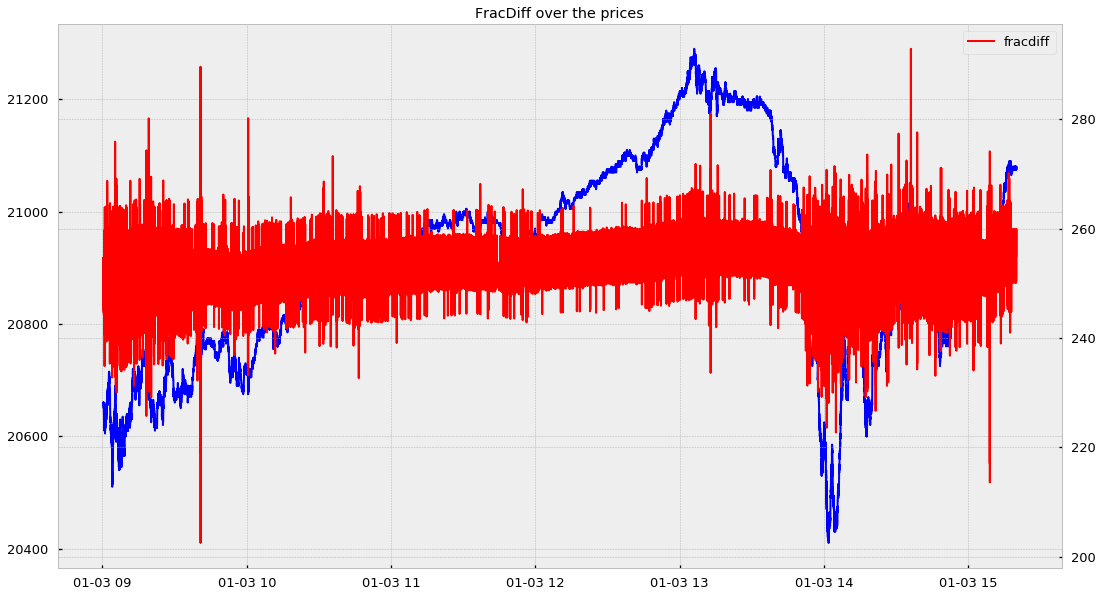

CPU times: user 859 ms, sys: 839 ms, total: 1.7 s
Wall time: 574 ms


In [33]:
%%time
frac_df = features.frac_diff_ffd(close0['close'], 0.9, thres=1e-3)
plot_fd(close0, frac_df)

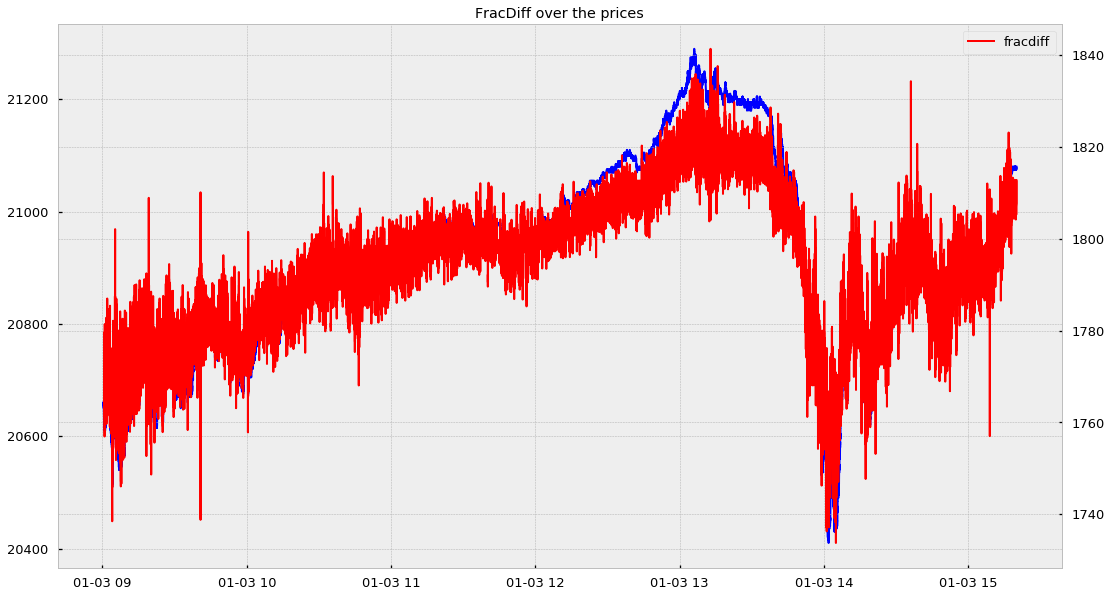

CPU times: user 729 ms, sys: 899 ms, total: 1.63 s
Wall time: 503 ms


In [34]:
%%time
frac_df = features.frac_diff_ffd(close0['close'], 0.5, thres=1e-3)
plot_fd(close0, frac_df)

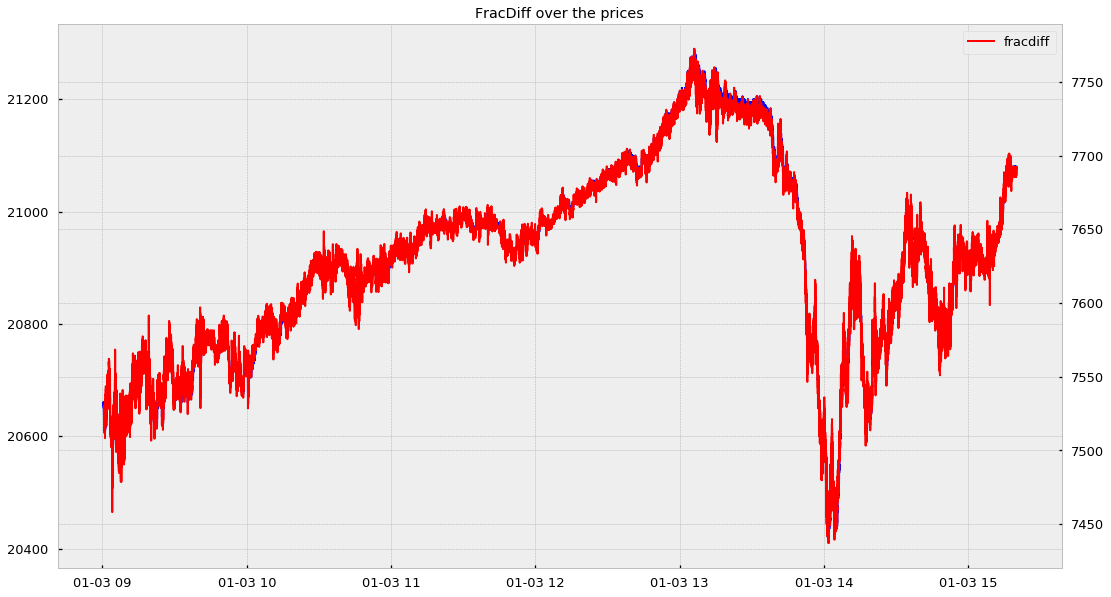

CPU times: user 745 ms, sys: 930 ms, total: 1.67 s
Wall time: 490 ms


In [39]:
%%time
frac_df = features.frac_diff_ffd(close0['close'], 0.2, thres=1e-3)
plot_fd(close0, frac_df)

# APPENDIX